In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import torchvision.transforms as T
import pandas as pd
import numpy as np
from PIL import Image
from pathlib import Path
from collections import defaultdict
from tqdm import tqdm
import matplotlib.pyplot as plt

from augmentation import apply_random_augmentations

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

Using device: cuda


In [2]:
DATA_ROOT = Path('animal-clef-2025')
SPLITS_DIR = DATA_ROOT / 'splits'

EMBEDDING_DIM = 128
M = 8
K = 4
BATCH_SIZE = M * K
LR = 1e-4
EPOCHS = 50
MARGIN = 0.3
IMAGE_SIZE = 224

In [ ]:
train_df = pd.read_csv(SPLITS_DIR / 'train.csv')
valid_seen_df = pd.read_csv(SPLITS_DIR / 'valid_seen.csv')
valid_unseen_df = pd.read_csv(SPLITS_DIR / 'valid_unseen.csv')
test_seen_df = pd.read_csv(SPLITS_DIR / 'test_seen.csv')
test_unseen_df = pd.read_csv(SPLITS_DIR / 'test_unseen.csv')

metadata_df = pd.read_csv(DATA_ROOT / 'metadata.csv')
query_df = metadata_df[metadata_df['split'] == 'query'].copy()

Train: 9186 images, 705 identities
Valid seen: 1173 images, 605 identities
Valid unseen: 850 images, 198 identities
Test seen: 1273 images, 705 identities
Test unseen: 592 images, 199 identities
Query: 2135 images


In [4]:
class TripletDataset(Dataset):
    def __init__(self, df, data_root, m, k, transform=None, augment=True):
        self.df = df
        self.data_root = Path(data_root)
        self.m = m
        self.k = k
        self.transform = transform
        self.augment = augment

        self.identity_to_indices = defaultdict(list)
        for idx, row in df.iterrows():
            self.identity_to_indices[row['identity']].append(idx)

        self.identities = list(self.identity_to_indices.keys())
        self.identity_to_label = {id_: i for i, id_ in enumerate(self.identities)}
        self.n_batches = len(self.identities) // m

        self.samples = []
        self.resample()

    def resample(self):
        self.samples = []
        shuffled_identities = np.random.permutation(self.identities)

        for batch_idx in range(self.n_batches):
            batch_identities = shuffled_identities[batch_idx * self.m:(batch_idx + 1) * self.m]

            for identity in batch_identities:
                indices = self.identity_to_indices[identity]

                if len(indices) >= self.k:
                    chosen = np.random.choice(indices, self.k, replace=False)
                else:
                    chosen = list(np.random.choice(indices, len(indices), replace=False))
                    extra = np.random.choice(indices, self.k - len(indices), replace=True)
                    chosen = chosen + list(extra)

                label = self.identity_to_label[identity]
                for img_idx in chosen:
                    self.samples.append((img_idx, label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_idx, label = self.samples[idx]

        row = self.df.loc[img_idx]
        img_path = self.data_root / row['path']
        image = Image.open(img_path).convert('RGB')

        if self.augment:
            image = apply_random_augmentations(image)

        if self.transform:
            image = self.transform(image)

        return image, label

In [5]:
class SimpleDataset(Dataset):
    def __init__(self, df, data_root, transform=None):
        self.df = df.reset_index(drop=True)
        self.data_root = Path(data_root)
        self.transform = transform
        
        self.identities = sorted(df['identity'].unique())
        self.identity_to_label = {id_: i for i, id_ in enumerate(self.identities)}
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = self.data_root / row['path']
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        label = self.identity_to_label[row['identity']]
        identity = row['identity']
        
        return image, label, identity

In [6]:
class QueryDataset(Dataset):
    def __init__(self, df, data_root, transform=None):
        self.df = df.reset_index(drop=True)
        self.data_root = Path(data_root)
        self.transform = transform
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = self.data_root / row['path']
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        return image, row['image_id']

In [7]:
class EmbeddingModel(nn.Module):
    def __init__(self, embedding_dim=128):
        super().__init__()
        resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
        self.backbone = nn.Sequential(*list(resnet.children())[:-1])
        self.fc = nn.Linear(2048, embedding_dim)
    
    def forward(self, x):
        x = self.backbone(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = F.normalize(x, p=2, dim=1)
        return x

In [8]:
class BatchHardTripletLoss(nn.Module):
    def __init__(self, margin=0.3):
        super().__init__()
        self.margin = margin
    
    def forward(self, embeddings, labels):
        pairwise_dist = torch.cdist(embeddings, embeddings, p=2)
        
        labels = labels.unsqueeze(0)
        mask_positive = (labels == labels.T).float()
        mask_negative = (labels != labels.T).float()
        
        mask_positive.fill_diagonal_(0)
        
        hardest_positive_dist = (pairwise_dist * mask_positive).max(dim=1)[0]
        
        max_dist = pairwise_dist.max()
        pairwise_dist_neg = pairwise_dist + max_dist * (1 - mask_negative)
        hardest_negative_dist = pairwise_dist_neg.min(dim=1)[0]
        
        triplet_loss = F.relu(hardest_positive_dist - hardest_negative_dist + self.margin)
        
        valid_triplets = (hardest_positive_dist > 0).float()
        loss = (triplet_loss * valid_triplets).sum() / (valid_triplets.sum() + 1e-8)
        
        return loss

In [9]:
train_transform = T.Compose([
    T.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = T.Compose([
    T.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
train_dataset = TripletDataset(train_df, DATA_ROOT, M, K, transform=train_transform, augment=True)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

train_eval_dataset = SimpleDataset(train_df, DATA_ROOT, transform=val_transform)
train_eval_loader = DataLoader(train_eval_dataset, batch_size=64, shuffle=False, num_workers=0)

valid_seen_dataset = SimpleDataset(valid_seen_df, DATA_ROOT, transform=val_transform)
valid_seen_loader = DataLoader(valid_seen_dataset, batch_size=64, shuffle=False, num_workers=0)

valid_unseen_dataset = SimpleDataset(valid_unseen_df, DATA_ROOT, transform=val_transform)
valid_unseen_loader = DataLoader(valid_unseen_dataset, batch_size=64, shuffle=False, num_workers=0)

test_seen_dataset = SimpleDataset(test_seen_df, DATA_ROOT, transform=val_transform)
test_seen_loader = DataLoader(test_seen_dataset, batch_size=64, shuffle=False, num_workers=0)

test_unseen_dataset = SimpleDataset(test_unseen_df, DATA_ROOT, transform=val_transform)
test_unseen_loader = DataLoader(test_unseen_dataset, batch_size=64, shuffle=False, num_workers=0)

query_dataset = QueryDataset(query_df, DATA_ROOT, transform=val_transform)
query_loader = DataLoader(query_dataset, batch_size=64, shuffle=False, num_workers=0)

print(f'train batches: {len(train_loader)}')
print(f'valid seen batches: {len(valid_seen_loader)}')
print(f'test seen batches: {len(test_seen_loader)}')
print(f'query batches: {len(query_loader)}')

Train batches: 88
Valid seen batches: 19
Test seen batches: 20
Query batches: 34


In [11]:
model = EmbeddingModel(embedding_dim=EMBEDDING_DIM).to(device)
criterion = BatchHardTripletLoss(margin=MARGIN)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [ ]:
def extract_embeddings(model, loader):
    model.eval()
    embeddings = []
    labels = []
    identities = []
    
    with torch.no_grad():
        for images, lbls, ids in tqdm(loader, desc='extracting embeddings'):
            images = images.to(device)
            emb = model(images)
            embeddings.append(emb.cpu())
            labels.extend(lbls.numpy())
            identities.extend(ids)
    
    embeddings = torch.cat(embeddings, dim=0)
    return embeddings, np.array(labels), identities


def extract_query_embeddings(model, loader):
    model.eval()
    embeddings = []
    image_ids = []
    
    with torch.no_grad():
        for images, img_ids in tqdm(loader, desc='extracting query embeddings'):
            images = images.to(device)
            emb = model(images)
            embeddings.append(emb.cpu())
            image_ids.extend(img_ids.numpy())
    
    embeddings = torch.cat(embeddings, dim=0)
    return embeddings, image_ids

In [13]:
def compute_balanced_rank_k(query_emb, gallery_emb, query_ids, gallery_ids, k=1):
    dists = torch.cdist(query_emb, gallery_emb, p=2)
    _, indices = dists.topk(k, dim=1, largest=False)
    
    identity_correct = defaultdict(list)
    for i, idx in enumerate(indices):
        retrieved_ids = [gallery_ids[j] for j in idx.numpy()]
        correct = 1 if query_ids[i] in retrieved_ids else 0
        identity_correct[query_ids[i]].append(correct)
    
    per_identity_acc = []
    for identity, corrects in identity_correct.items():
        per_identity_acc.append(np.mean(corrects))
    
    return np.mean(per_identity_acc)

In [14]:
def evaluate_training(model, train_loader, valid_loader):
    train_emb, _, train_ids = extract_embeddings(model, train_loader)
    valid_emb, _, valid_ids = extract_embeddings(model, valid_loader)
    
    rank1 = compute_balanced_rank_k(valid_emb, train_emb, valid_ids, train_ids, k=1)
    rank5 = compute_balanced_rank_k(valid_emb, train_emb, valid_ids, train_ids, k=5)
    
    return rank1, rank5

In [ ]:
history = {
    'train_loss': [],
    'valid_balanced_rank1': [],
    'valid_balanced_rank5': []
}

for epoch in range(EPOCHS):
    train_dataset.resample()

    model.train()
    epoch_loss = 0
    n_batches = 0

    pbar = tqdm(train_loader, desc=f'epoch {epoch+1}/{EPOCHS}')
    for images, labels in pbar:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        embeddings = model(images)
        loss = criterion(embeddings, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        n_batches += 1
        pbar.set_postfix({'loss': epoch_loss / n_batches})

    avg_loss = epoch_loss / n_batches
    history['train_loss'].append(avg_loss)

    rank1, rank5 = evaluate_training(model, train_eval_loader, valid_seen_loader)
    history['valid_balanced_rank1'].append(rank1)
    history['valid_balanced_rank5'].append(rank5)

    print(f'epoch {epoch+1}: loss={avg_loss:.4f}, balanced rank-1={rank1:.4f}, balanced rank-5={rank5:.4f}')

Extracting embeddings: 100%|███████████████████████████████████████████████████████████| 19/19 [00:40<00:00,  2.14s/it]


Epoch 1: Loss=0.3850, Balanced Rank-1=0.1603, Balanced Rank-5=0.3008


Extracting embeddings: 100%|███████████████████████████████████████████████████████████| 19/19 [00:19<00:00,  1.05s/it]


Epoch 2: Loss=0.3448, Balanced Rank-1=0.1843, Balanced Rank-5=0.3223


Extracting embeddings: 100%|███████████████████████████████████████████████████████████| 19/19 [00:19<00:00,  1.03s/it]


Epoch 3: Loss=0.3239, Balanced Rank-1=0.1866, Balanced Rank-5=0.3136


Extracting embeddings: 100%|███████████████████████████████████████████████████████████| 19/19 [00:19<00:00,  1.05s/it]


Epoch 4: Loss=0.3044, Balanced Rank-1=0.2164, Balanced Rank-5=0.3415


Extracting embeddings: 100%|███████████████████████████████████████████████████████████| 19/19 [00:19<00:00,  1.04s/it]


Epoch 5: Loss=0.2950, Balanced Rank-1=0.2314, Balanced Rank-5=0.3768


Extracting embeddings: 100%|███████████████████████████████████████████████████████████| 19/19 [00:20<00:00,  1.06s/it]


Epoch 6: Loss=0.2835, Balanced Rank-1=0.2489, Balanced Rank-5=0.3816


Extracting embeddings: 100%|███████████████████████████████████████████████████████████| 19/19 [00:19<00:00,  1.04s/it]


Epoch 7: Loss=0.2815, Balanced Rank-1=0.2753, Balanced Rank-5=0.4029


Extracting embeddings: 100%|███████████████████████████████████████████████████████████| 19/19 [00:20<00:00,  1.06s/it]


Epoch 8: Loss=0.2742, Balanced Rank-1=0.2737, Balanced Rank-5=0.3981


Extracting embeddings: 100%|███████████████████████████████████████████████████████████| 19/19 [00:19<00:00,  1.04s/it]


Epoch 9: Loss=0.2635, Balanced Rank-1=0.2653, Balanced Rank-5=0.3994


Extracting embeddings: 100%|███████████████████████████████████████████████████████████| 19/19 [00:19<00:00,  1.05s/it]


Epoch 10: Loss=0.2534, Balanced Rank-1=0.2889, Balanced Rank-5=0.4249


Extracting embeddings: 100%|███████████████████████████████████████████████████████████| 19/19 [00:19<00:00,  1.04s/it]


Epoch 11: Loss=0.2582, Balanced Rank-1=0.2713, Balanced Rank-5=0.4150


Extracting embeddings: 100%|███████████████████████████████████████████████████████████| 19/19 [00:19<00:00,  1.04s/it]


Epoch 12: Loss=0.2516, Balanced Rank-1=0.3122, Balanced Rank-5=0.4516


Extracting embeddings: 100%|███████████████████████████████████████████████████████████| 19/19 [00:20<00:00,  1.06s/it]


Epoch 13: Loss=0.2525, Balanced Rank-1=0.3431, Balanced Rank-5=0.4644


Extracting embeddings: 100%|███████████████████████████████████████████████████████████| 19/19 [00:19<00:00,  1.05s/it]


Epoch 14: Loss=0.2442, Balanced Rank-1=0.3290, Balanced Rank-5=0.4512


Extracting embeddings: 100%|███████████████████████████████████████████████████████████| 19/19 [00:19<00:00,  1.04s/it]


Epoch 15: Loss=0.2421, Balanced Rank-1=0.3251, Balanced Rank-5=0.4579


Extracting embeddings: 100%|███████████████████████████████████████████████████████████| 19/19 [00:19<00:00,  1.04s/it]


Epoch 16: Loss=0.2385, Balanced Rank-1=0.3432, Balanced Rank-5=0.4640


Extracting embeddings: 100%|███████████████████████████████████████████████████████████| 19/19 [00:19<00:00,  1.04s/it]


Epoch 17: Loss=0.2410, Balanced Rank-1=0.3278, Balanced Rank-5=0.4791


Extracting embeddings: 100%|███████████████████████████████████████████████████████████| 19/19 [00:19<00:00,  1.04s/it]


Epoch 18: Loss=0.2405, Balanced Rank-1=0.3298, Balanced Rank-5=0.4674


Extracting embeddings: 100%|███████████████████████████████████████████████████████████| 19/19 [00:19<00:00,  1.03s/it]


Epoch 19: Loss=0.2376, Balanced Rank-1=0.3275, Balanced Rank-5=0.4465


Extracting embeddings: 100%|███████████████████████████████████████████████████████████| 19/19 [00:19<00:00,  1.05s/it]


Epoch 20: Loss=0.2338, Balanced Rank-1=0.3333, Balanced Rank-5=0.4917


Extracting embeddings: 100%|███████████████████████████████████████████████████████████| 19/19 [00:13<00:00,  1.44it/s]


Epoch 21: Loss=0.2227, Balanced Rank-1=0.3393, Balanced Rank-5=0.4996


Extracting embeddings: 100%|███████████████████████████████████████████████████████████| 19/19 [00:13<00:00,  1.37it/s]


Epoch 22: Loss=0.2232, Balanced Rank-1=0.3316, Balanced Rank-5=0.4888


Extracting embeddings: 100%|███████████████████████████████████████████████████████████| 19/19 [00:16<00:00,  1.13it/s]


Epoch 23: Loss=0.2209, Balanced Rank-1=0.3458, Balanced Rank-5=0.4877


Extracting embeddings: 100%|███████████████████████████████████████████████████████████| 19/19 [00:19<00:00,  1.04s/it]


Epoch 24: Loss=0.2179, Balanced Rank-1=0.3543, Balanced Rank-5=0.5078


Extracting embeddings: 100%|███████████████████████████████████████████████████████████| 19/19 [00:19<00:00,  1.03s/it]


Epoch 25: Loss=0.2184, Balanced Rank-1=0.3550, Balanced Rank-5=0.4750


Extracting embeddings: 100%|███████████████████████████████████████████████████████████| 19/19 [00:19<00:00,  1.03s/it]


Epoch 26: Loss=0.2153, Balanced Rank-1=0.3318, Balanced Rank-5=0.4878


Extracting embeddings: 100%|███████████████████████████████████████████████████████████| 19/19 [00:19<00:00,  1.03s/it]


Epoch 27: Loss=0.2171, Balanced Rank-1=0.3393, Balanced Rank-5=0.4969


Extracting embeddings: 100%|███████████████████████████████████████████████████████████| 19/19 [00:19<00:00,  1.02s/it]


Epoch 28: Loss=0.2182, Balanced Rank-1=0.3218, Balanced Rank-5=0.4820


Extracting embeddings: 100%|███████████████████████████████████████████████████████████| 19/19 [00:19<00:00,  1.01s/it]


Epoch 29: Loss=0.2129, Balanced Rank-1=0.3715, Balanced Rank-5=0.4916


Extracting embeddings: 100%|███████████████████████████████████████████████████████████| 19/19 [00:19<00:00,  1.03s/it]


Epoch 30: Loss=0.2098, Balanced Rank-1=0.3685, Balanced Rank-5=0.5064


Extracting embeddings: 100%|███████████████████████████████████████████████████████████| 19/19 [00:19<00:00,  1.05s/it]


Epoch 31: Loss=0.2089, Balanced Rank-1=0.3628, Balanced Rank-5=0.5004


Extracting embeddings: 100%|███████████████████████████████████████████████████████████| 19/19 [00:20<00:00,  1.10s/it]


Epoch 32: Loss=0.2129, Balanced Rank-1=0.3713, Balanced Rank-5=0.4998


Extracting embeddings: 100%|███████████████████████████████████████████████████████████| 19/19 [00:20<00:00,  1.09s/it]


Epoch 33: Loss=0.2096, Balanced Rank-1=0.3585, Balanced Rank-5=0.5003


Extracting embeddings: 100%|███████████████████████████████████████████████████████████| 19/19 [00:20<00:00,  1.08s/it]


Epoch 34: Loss=0.2111, Balanced Rank-1=0.3601, Balanced Rank-5=0.5030


Extracting embeddings: 100%|███████████████████████████████████████████████████████████| 19/19 [00:20<00:00,  1.08s/it]


Epoch 35: Loss=0.2127, Balanced Rank-1=0.3690, Balanced Rank-5=0.4943


Extracting embeddings: 100%|███████████████████████████████████████████████████████████| 19/19 [00:20<00:00,  1.07s/it]


Epoch 36: Loss=0.2022, Balanced Rank-1=0.3515, Balanced Rank-5=0.4766


Extracting embeddings: 100%|███████████████████████████████████████████████████████████| 19/19 [00:19<00:00,  1.03s/it]


Epoch 37: Loss=0.2060, Balanced Rank-1=0.3689, Balanced Rank-5=0.5096


Extracting embeddings: 100%|███████████████████████████████████████████████████████████| 19/19 [00:19<00:00,  1.03s/it]


Epoch 38: Loss=0.2065, Balanced Rank-1=0.3744, Balanced Rank-5=0.5137


Extracting embeddings: 100%|███████████████████████████████████████████████████████████| 19/19 [00:19<00:00,  1.05s/it]


Epoch 39: Loss=0.2054, Balanced Rank-1=0.3694, Balanced Rank-5=0.5176


Extracting embeddings: 100%|███████████████████████████████████████████████████████████| 19/19 [00:19<00:00,  1.05s/it]


Epoch 40: Loss=0.1958, Balanced Rank-1=0.3630, Balanced Rank-5=0.5162


Extracting embeddings: 100%|███████████████████████████████████████████████████████████| 19/19 [00:19<00:00,  1.05s/it]


Epoch 41: Loss=0.2049, Balanced Rank-1=0.3656, Balanced Rank-5=0.4928


Extracting embeddings: 100%|███████████████████████████████████████████████████████████| 19/19 [00:19<00:00,  1.05s/it]


Epoch 42: Loss=0.2026, Balanced Rank-1=0.3845, Balanced Rank-5=0.5226


Extracting embeddings: 100%|███████████████████████████████████████████████████████████| 19/19 [00:20<00:00,  1.06s/it]


Epoch 43: Loss=0.2055, Balanced Rank-1=0.3804, Balanced Rank-5=0.5208


Extracting embeddings: 100%|███████████████████████████████████████████████████████████| 19/19 [00:19<00:00,  1.05s/it]


Epoch 44: Loss=0.1998, Balanced Rank-1=0.3611, Balanced Rank-5=0.4976


Extracting embeddings: 100%|███████████████████████████████████████████████████████████| 19/19 [00:19<00:00,  1.04s/it]


Epoch 45: Loss=0.1996, Balanced Rank-1=0.3584, Balanced Rank-5=0.5127


Extracting embeddings: 100%|███████████████████████████████████████████████████████████| 19/19 [00:19<00:00,  1.05s/it]


Epoch 46: Loss=0.1959, Balanced Rank-1=0.3597, Balanced Rank-5=0.5328


Extracting embeddings: 100%|███████████████████████████████████████████████████████████| 19/19 [00:19<00:00,  1.04s/it]


Epoch 47: Loss=0.1967, Balanced Rank-1=0.3839, Balanced Rank-5=0.5231


Extracting embeddings: 100%|███████████████████████████████████████████████████████████| 19/19 [00:20<00:00,  1.05s/it]


Epoch 48: Loss=0.1982, Balanced Rank-1=0.3687, Balanced Rank-5=0.5057


Extracting embeddings: 100%|███████████████████████████████████████████████████████████| 19/19 [00:19<00:00,  1.02s/it]


Epoch 49: Loss=0.1970, Balanced Rank-1=0.3629, Balanced Rank-5=0.5016


Extracting embeddings: 100%|███████████████████████████████████████████████████████████| 19/19 [00:20<00:00,  1.06s/it]


Epoch 50: Loss=0.1983, Balanced Rank-1=0.3505, Balanced Rank-5=0.4925


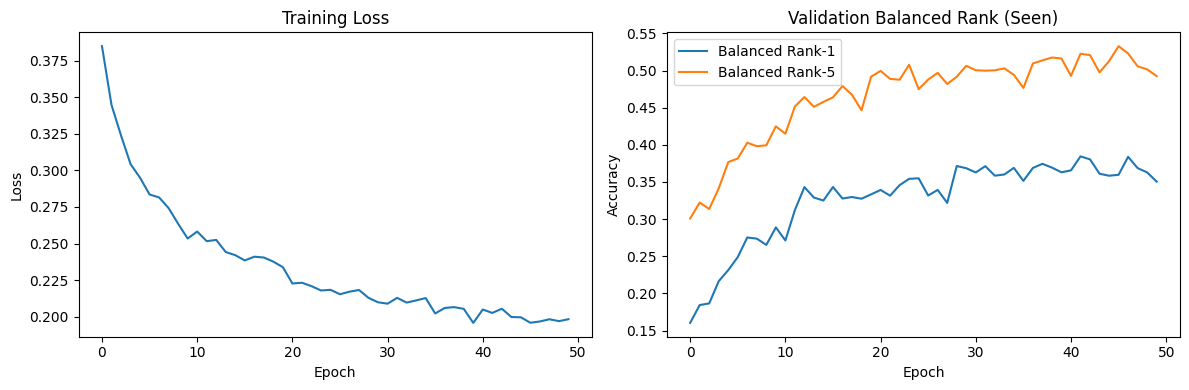

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(history['train_loss'])
axes[0].set_xlabel('epoch')
axes[0].set_ylabel('loss')
axes[0].set_title('training loss')

axes[1].plot(history['valid_balanced_rank1'], label='balanced rank-1')
axes[1].plot(history['valid_balanced_rank5'], label='balanced rnk-5')
axes[1].set_xlabel('epoch')
axes[1].set_ylabel('accuracy')
axes[1].set_title('validation balanced rank (seen)')
axes[1].legend()

plt.tight_layout()
plt.savefig('training_curves.png', dpi=150)
plt.show()

In [ ]:
train_emb, _, train_ids = extract_embeddings(model, train_eval_loader)
valid_seen_emb, _, valid_seen_ids = extract_embeddings(model, valid_seen_loader)
valid_unseen_emb, _, valid_unseen_ids = extract_embeddings(model, valid_unseen_loader)

train_id_to_emb = defaultdict(list)
for emb, id_ in zip(train_emb, train_ids):
    train_id_to_emb[id_].append(emb)

train_centroids = {}
for id_, embs in train_id_to_emb.items():
    centroid = torch.stack(embs).mean(dim=0)
    centroid = F.normalize(centroid, p=2, dim=0)
    train_centroids[id_] = centroid

centroid_ids = list(train_centroids.keys())
centroid_emb = torch.stack([train_centroids[id_] for id_ in centroid_ids])

Extracting embeddings for threshold optimization...


Extracting embeddings: 100%|███████████████████████████████████████████████████████████| 14/14 [00:34<00:00,  2.44s/it]


In [18]:
def get_min_distances_and_predictions(query_emb, gallery_emb, centroid_ids):
    dists = torch.cdist(query_emb, gallery_emb, p=2)
    min_dists, min_idx = dists.min(dim=1)
    predicted_ids = [centroid_ids[i] for i in min_idx.numpy()]
    return min_dists.numpy(), predicted_ids

seen_min_dists, seen_pred_ids = get_min_distances_and_predictions(valid_seen_emb, centroid_emb, centroid_ids)
unseen_min_dists, _ = get_min_distances_and_predictions(valid_unseen_emb, centroid_emb, centroid_ids)

In [19]:
def compute_baks(true_ids, pred_ids, dists, threshold):
    identity_correct = defaultdict(list)
    for true_id, pred_id, dist in zip(true_ids, pred_ids, dists):
        if dist < threshold and true_id == pred_id:
            identity_correct[true_id].append(1)
        else:
            identity_correct[true_id].append(0)
    
    per_identity_acc = [np.mean(corrects) for corrects in identity_correct.values()]
    return np.mean(per_identity_acc)


def compute_baus(dists, ids, threshold):
    is_unseen_pred = dists >= threshold
    identity_correct = defaultdict(list)
    for id_, is_unseen in zip(ids, is_unseen_pred):
        identity_correct[id_].append(1 if is_unseen else 0)
    
    per_identity_acc = [np.mean(v) for v in identity_correct.values()]
    return np.mean(per_identity_acc)

In [ ]:
all_dists = np.concatenate([seen_min_dists, unseen_min_dists])
thresholds = np.linspace(all_dists.min(), all_dists.max(), 100)

best_threshold = 0
best_score = 0

for thresh in thresholds:
    baks = compute_baks(valid_seen_ids, seen_pred_ids, seen_min_dists, thresh)
    baus = compute_baus(unseen_min_dists, valid_unseen_ids, thresh)
    
    if baks > 0 and baus > 0:
        harmonic = 2 * baks * baus / (baks + baus)
    else:
        harmonic = 0
    
    if harmonic > best_score:
        best_score = harmonic
        best_threshold = thresh

print(f'best threshold= {best_threshold:.4f} harmonic mean={best_score:.4f}')

Best threshold: 0.5109 (Harmonic mean=0.3789)


In [ ]:
test_seen_emb, _, test_seen_ids = extract_embeddings(model, test_seen_loader)
test_unseen_emb, _, test_unseen_ids = extract_embeddings(model, test_unseen_loader)

Extracting test embeddings...


Extracting embeddings: 100%|███████████████████████████████████████████████████████████| 10/10 [00:23<00:00,  2.32s/it]


In [ ]:
test_seen_dists, test_seen_pred_ids = get_min_distances_and_predictions(test_seen_emb, centroid_emb, centroid_ids)
test_unseen_dists, _ = get_min_distances_and_predictions(test_unseen_emb, centroid_emb, centroid_ids)

balanced_rank5 = compute_balanced_rank_k(test_seen_emb, train_emb, test_seen_ids, train_ids, k=5)
baks = compute_baks(test_seen_ids, test_seen_pred_ids, test_seen_dists, best_threshold)
baus = compute_baus(test_unseen_dists, test_unseen_ids, best_threshold)

print('final metrics on test set:')
print(f'threshold: {best_threshold:.4f}')
print(f'balanced rank-5 (known): {balanced_rank5:.4f}')
print(f'baks (balanced accuracy on known samples): {baks:.4f}')
print(f'baus (balanced accuracy on unknown samples): {baus:.4f}')
print(f'test known: {len(test_seen_ids)} images, {len(set(test_seen_ids))} identities')
print(f'test unknown: {len(test_unseen_ids)} images, {len(set(test_unseen_ids))} identities')

FINAL TEST METRICS
Threshold: 0.5109

Balanced Rank-5 (known): 0.4945
BAKS (Balanced Accuracy on Known Samples): 0.2577
BAUS (Balanced Accuracy on Unknown Samples): 0.8122

Test known: 1273 images, 705 identities
Test unknown: 592 images, 199 identities


In [23]:
query_emb, query_image_ids = extract_query_embeddings(model, query_loader)

query_dists, query_pred_ids = get_min_distances_and_predictions(query_emb, centroid_emb, centroid_ids)
query_is_seen = query_dists < best_threshold

predictions = []
for img_id, pred_id, is_seen in zip(query_image_ids, query_pred_ids, query_is_seen):
    if is_seen:
        predictions.append({'image_id': img_id, 'identity': pred_id})
    else:
        predictions.append({'image_id': img_id, 'identity': 'new_individual'})

submission_df = pd.DataFrame(predictions)
submission_df = submission_df.sort_values('image_id')
submission_df.to_csv('submission.csv', index=False)

Extracting query embeddings: 100%|█████████████████████████████████████████████████████| 34/34 [01:58<00:00,  3.50s/it]


In [ ]:
torch.save({
    'model_state_dict': model.state_dict(),
    'threshold': best_threshold,
    'centroid_ids': centroid_ids,
    'centroid_emb': centroid_emb,
    'history': history,
    'test_metrics': {
        'balanced_rank5': balanced_rank5,
        'baks': baks,
        'baus': baus
    }
}, 'model_checkpoint.pt')

Model saved to model_checkpoint.pt
